In [1]:
from Bio import Phylo
from io import StringIO
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/gc3045/git_packages/startle/scripts')
from utilities import * # startle

dirname = "/Users/gc3045/scmail_v1/sc-mail-experiments/Real_biodata/kptracer/result_trees/pruned_1461"
problin_file = f"{dirname}/problin_1461.nwk"

startle_file = f"{dirname}/startle_1461.nwk"
casshybrid_file = f"{dirname}/casshybrid_1461.nwk"

df_kp_meta = pd.read_csv(f'{dirname}/KPTracer_meta.csv', index_col = 0)
df_character_matrix_Fam_1 = pd.read_csv(f'{dirname}/character_matrix_dedup.csv',
                                        index_col = 0, sep=',', dtype=str)


In [2]:
cell_site_info_1 = df_kp_meta.loc[df_character_matrix_Fam_1.index]['SubTumor']
for cell, site in cell_site_info_1.items():
    if len(site.split('_')) > 3:
        cell_site_info_1[cell] = '_'.join(site.split('_')[:-1])
        
cell_site_info_2 = df_kp_meta.loc[df_character_matrix_Fam_1.index]['SubTumor']
for cell, site in cell_site_info_2.items():
    if len(site.split('_')) > 3: 
        cell_site_info_2[cell] = '_'.join(site.split('_')[-2:])

In [3]:
def get_brlen(u, v, edge_attr):
    return edge_attr['weight']
    
def computeG(T, cell_site_info, state_list, cost_labeling, presence_labeling, node):
    min_cost = min(cost_labeling[node])
    if node == 'root':
         for state_idx in range(len(state_list)):
                if cost_labeling[node][state_idx] == min_cost:
                    presence_labeling[node][state_idx] = 1
                else:
                    presence_labeling[node][state_idx] = 0
    else:
        
        parent_node = list(T.pred[node])[0]
        
        for state_idx in range(len(state_list)):
            presence_labeling[node][state_idx] = 0
        
        for parent_state_idx in range(len(state_list)):
            if presence_labeling[parent_node][parent_state_idx] == 1:

                min_cost = np.inf
                for child_state_idx, child_state in enumerate(state_list):
                    if child_state_idx == parent_state_idx:
                        curr_cost = cost_labeling[node][child_state_idx]
                    else:
                        curr_cost = cost_labeling[node][child_state_idx] + 1

                    if curr_cost < min_cost:
                        min_cost = curr_cost
        
                for child_state_idx in range(len(state_list)):
                    if child_state_idx == parent_state_idx:
                        curr_cost = cost_labeling[node][child_state_idx]
                    else:
                        curr_cost = cost_labeling[node][child_state_idx] + 1
                        
                    if curr_cost == min_cost:
                        presence_labeling[node][child_state_idx] = 1
                

    for child in T[node]:
        computeG(T, cell_site_info, state_list, cost_labeling, presence_labeling, child)
        
def update_parsimonious_labeling_counts(T, cell_site_info, state_list, cost_labeling, count_labeling, node):
    if is_leaf(T, node):
        for state_idx, state in enumerate(state_list):
            if state == cell_site_info[node]:
                cost_labeling[node][state_idx] = 0
                count_labeling[node][state_idx] = 1
            else:
                cost_labeling[node][state_idx] = np.inf
                count_labeling[node][state_idx] = 0
    else:
        for child in T[node]:
            update_parsimonious_labeling_counts(T, cell_site_info, state_list, cost_labeling, count_labeling, child)
        
        for parent_state_idx, state in enumerate(state_list):
            cost_labeling[node][parent_state_idx] = 0
            count_labeling[node][parent_state_idx] = 1
            for child in T[node]:
                min_cost = np.inf
                for child_state_idx, child_state in enumerate(state_list):
                    if child_state_idx == parent_state_idx:
                        curr_cost = cost_labeling[child][child_state_idx]
                    else:
                        curr_cost = cost_labeling[child][child_state_idx] + 1

                    if curr_cost < min_cost:
                        min_cost = curr_cost
                        min_child_state_idx = child_state_idx

                cost_labeling[node][parent_state_idx] += min_cost

                curr_child_total_count = 0
                for child_state_idx, child_state in enumerate(state_list):
                    if child_state_idx == parent_state_idx:
                        curr_cost = cost_labeling[child][child_state_idx]
                    else:
                        curr_cost = cost_labeling[child][child_state_idx] + 1

                    if curr_cost == min_cost:
                        curr_child_total_count += count_labeling[child][child_state_idx]

                count_labeling[node][parent_state_idx] *= curr_child_total_count

def count_parsimonious_labelings(T, cell_site_info):
    state_list = list(cell_site_info.unique())
    nstates = len(state_list)
    # state_transition_counter = Counter()
    node_cost_labeling = {node:[None]*nstates for node in T.nodes}
    # print(T.nodes)
    # print(node_cost_labeling['root'])
    node_count_labeling = {node:[None]*nstates for node in T.nodes}
    update_parsimonious_labeling_counts(T, cell_site_info, state_list, node_cost_labeling, node_count_labeling, 'root')
    
    return node_cost_labeling, node_count_labeling
    
def count_transitions(input_tree, cell_site_info, throw_out_identical_sites=True):
    num_leaves = 0
    for n in input_tree.nodes:
        if is_leaf(input_tree, n): 
            num_leaves += 1
    
    print(f"input tree has {len(input_tree.nodes)} nodes and {num_leaves} leaves")
    if throw_out_identical_sites:
        input_tree = get_smaller_tree(input_tree, cell_site_info_1)
        print(f"modified tree has {len(input_tree.nodes)} nodes") 
    
    num_leaves = 0
    for n in input_tree.nodes:
        if is_leaf(input_tree, n): 
            num_leaves += 1
    print(f"modified tree has {num_leaves} leaves")
    cost_labeling, count_labeling = count_parsimonious_labelings(input_tree, cell_site_info)
    state_list = list(cell_site_info.unique())
    nstates = len(state_list)
    presence_labeling = {node:[None]*nstates for node in input_tree.nodes}
    computeG(input_tree, cell_site_info, state_list, cost_labeling, presence_labeling, 'root')

    optimal_labeling = {node:'' for node in input_tree.nodes}

    for node in input_tree.nodes:
        if presence_labeling[node][0] == 1:
            optimal_labeling[node] = 0
        else:
            optimal_labeling[node] = np.where(presence_labeling[node])[0][0]

    num_transitions = Counter()
    for edge in input_tree.edges:
        if optimal_labeling[edge[0]] != optimal_labeling[edge[1]]:
            num_transitions[(optimal_labeling[edge[0]], optimal_labeling[edge[1]])] += 1

    return optimal_labeling, presence_labeling, num_transitions, sum(num_transitions.values())


In [4]:
tree_path = problin_file #problin_file
if tree_path.startswith('[&R]'):
    handle = StringIO(tree_path)
    phylo_tree = Phylo.read(handle, 'newick')
    net_tree = Phylo.to_networkx(phylo_tree)
else:
    phylo_tree = Phylo.read(tree_path, 'newick')
    net_tree = Phylo.to_networkx(phylo_tree)

In [5]:
root = list(net_tree.nodes)[0]
new_net_tree = net_tree.copy()
node_renaming_mapping = {}
name_to_node = {}
idx = 0
for node in net_tree.nodes:
    if str(node) == 'Clade':
        node_renaming_mapping[node] = f'clade_{idx}'
        name_to_node[f'clade_{idx}'] = node
        idx = idx + 1
    else:
        node_renaming_mapping[node] = str(node)
        name_to_node[str(node)] = node
node_renaming_mapping[list(net_tree.nodes)[0]] = 'root'


In [6]:
new_net_tree = nx.relabel_nodes(new_net_tree, node_renaming_mapping)
for node in net_tree.nodes:
    if str(node) == 'Clade':
        node_renaming_mapping[node] = f'clade_{idx}'
        idx = idx + 1
    else:
        node_renaming_mapping[node] = str(node)

name_to_node['root'] = name_to_node['clade_0']

attrs = {}
for new_node in new_net_tree.nodes:
    #print("new_node", new_node)
    node = name_to_node[new_node]
    #print(new_net_tree.edges(new_node))
    for edge in new_net_tree.edges(new_node):
        #print("edge", edge)
        u, v = edge
        weight = net_tree[name_to_node[u]][name_to_node[v]]['weight']
        attrs[(u, v)] = {'weight': weight}

In [7]:

nx.set_edge_attributes(new_net_tree, attrs)
directed_tree = nx.DiGraph()
directed_tree.add_edges_from(list(nx.bfs_edges(new_net_tree, 'root')))
nx.set_edge_attributes(directed_tree, attrs)


In [8]:
problin_1461 = directed_tree
mapping = dict()
for i, name in enumerate(cell_site_info_1.unique()): 
    mapping[i] = name

In [9]:
input_tree = problin_1461
# def count_transition_heights(input_tree, use_weights=False): 
transition_heights = dict()
a_optimal_labeling, a_presence_labeling, a_transitions, a_cost = count_transitions(input_tree, cell_site_info_1, False)


input tree has 2921 nodes and 1461 leaves
modified tree has 1461 leaves


In [10]:
# get the number of metastases over # lineages

for edge in input_tree.edges:
    branch_len = input_tree.edges[edge]['weight']

    from_label = mapping[a_optimal_labeling[edge[0]]].strip()
    to_label = mapping[a_optimal_labeling[edge[1]]].strip()

    if from_label != to_label:
        from_primary = True if from_label == '3724_NT_T1' else False
        to_primary = True if to_label == '3724_NT_T1' else False
    
        if from_primary and to_primary:
            branch_type = "p2p_transition"
        elif from_primary and not to_primary:
            branch_type = "p2n_transition"
        elif not from_primary and not to_primary:
            branch_type = "n2n_transition"
            #print(from_label, to_label)
        elif not from_primary and to_primary:
            branch_type = "n2p_transition"
            # print(branch_type)
        else:
            branch_type = "hm?"
    else:
        branch_type = "not_transition"
    start_branch_height = nx.shortest_path_length(input_tree, source='root', target=edge[0], weight=get_brlen)
    end_branch_height = nx.shortest_path_length(input_tree, source='root', target=edge[1], weight=get_brlen)
    
    transition_heights[edge] = (start_branch_height, end_branch_height, branch_type)


In [11]:
transition_heights

{('root', 'clade_1'): (0, 0.19311067051961742, 'not_transition'),
 ('root', 'clade_7'): (0, 0.005, 'not_transition'),
 ('clade_1', 'clade_2'): (0.19311067051961742,
  0.6578658037152288,
  'not_transition'),
 ('clade_1', 'L8.CGGAGCTTCGGAAATA-1'): (0.19311067051961742,
  2.4760264849530227,
  'not_transition'),
 ('clade_7', 'clade_8'): (0.005, 0.7928975489609431, 'not_transition'),
 ('clade_7', 'clade_10'): (0.005, 0.01, 'not_transition'),
 ('clade_2', 'clade_3'): (0.6578658037152288,
  1.042211541826986,
  'not_transition'),
 ('clade_2', 'L9.CTGCGGAGTAGGCTGA-1'): (0.6578658037152288,
  2.4760264849530227,
  'not_transition'),
 ('clade_8', 'clade_9'): (0.7928975489609431,
  1.3899931442025095,
  'not_transition'),
 ('clade_8', 'L8.TCACGAATCCCATTAT-1'): (0.7928975489609431,
  2.4760272189148385,
  'not_transition'),
 ('clade_10', 'clade_11'): (0.01, 0.1360013610013078, 'not_transition'),
 ('clade_10', 'clade_815'): (0.01, 0.015, 'not_transition'),
 ('clade_3', 'L9.GAACATCTCTCTAGGA-1'): (

In [12]:
# get the first metastasis transition 
#earliest_start = 10
#earliest_meta = None
largest_meta = None
largest_size = 0
for edge in transition_heights: 
    f, t = edge

    branch_start, branch_end, branch_type = transition_heights[edge]

    # get earliest transition
    if branch_type == "p2n_transition": # and branch_start < earliest_start:
        #earliest_start = branch_start
        #earliest_meta = (edge, branch_start, branch_end, branch_type)
        subtree = nx.dfs_tree(input_tree, source=edge[0])
        leafset_parent = [n for n in subtree.nodes() if subtree.out_degree(n) == 0]
        #subtree = nx.dfs_tree(input_tree, source=edge[1])
        #leafset_child = [n for n in subtree.nodes() if subtree.out_degree(n) == 0]
        if len(leafset_parent) > largest_size:
            largest_size = len(leafset_parent)
            largest_meta = (edge, branch_start, branch_end, branch_type)

        
#print(earliest_meta)
print(largest_meta, largest_size)

(('clade_174', 'clade_273'), 0.747396309136499, 0.8988818280354804, 'p2n_transition') 594


In [13]:
largest_branch_end = 0
for edge in transition_heights:
    branch_start, branch_end, branch_type = transition_heights[edge]
    largest_branch_end = max(largest_branch_end, branch_end)
print(largest_branch_end)

2.4762221766950443


In [14]:
0.8988818280354804 * 6 / 2.4762221766950443

2.1780319306449236

In [15]:
0.747396309136499 * 6 / 2.4762221766950443

1.8109755647226247

In [16]:
def get_leaf_set(input_tree, node_name):
    subtree = nx.dfs_tree(input_tree, source=node_name)
    leafset = [n for n in subtree.nodes() if subtree.out_degree(n) == 0]
    return subtree, leafset

In [17]:
_, leafset_parent = get_leaf_set(input_tree, largest_meta[0][0])
_, leafset_child = get_leaf_set(input_tree, largest_meta[0][1])

In [18]:
len(leafset_child), len(leafset_parent)

(495, 594)

In [19]:
# check that leafset1 is a subset of leafset2
set1 = set(leafset_parent)
set2 = set(leafset_child)

is_subset = set2.issubset(set1)
is_subset

True

### specific indels that are associated with the metastatic dynamics


In [20]:
leafset_child

['L11.AAGACCTTCCAGAAGG-1',
 'L9.GACCTGGGTCAGAAGC-1',
 'L9.GCTGCGATCGCGCCAA-1',
 'L11.CGCTATCTCACAAACC-1',
 'L11.ATAACGCTCCTTTACA-1',
 'L11.CGGGTCAGTCTTCTCG-1',
 'L9.CACACTCCAAGTTCTG-1',
 'L11.GAAATGATCTCAAGTG-1',
 'L11.TTAGGACCACCGATAT-1',
 'L11.CTTGGCTGTAAACACA-1',
 'L9.GTAGGCCGTACTTAGC-1',
 'L11.CGACCTTTCCCATTTA-1',
 'L11.ACGAGCCGTCAAGCGA-1',
 'L11.GGTATTGCACGCCAGT-1',
 'L11.CGTGTCTAGTGACTCT-1',
 'L11.TAGTGGTCAGTATAAG-1',
 'L9.CCTACACCACCCTATC-1',
 'L11.AACTCCCTCAGCGACC-1',
 'L11.TAAACCGTCCAAGTAC-1',
 'L11.GGAGCAAAGTTACCCA-1',
 'L9.TGGGAAGAGCTGCCCA-1',
 'L9.GCAGCCACATCCTTGC-1',
 'L11.GGAATAAAGTTGAGAT-1',
 'L11.ACACCCTTCTAAGCCA-1',
 'L11.CTGGTCTCACTTGGAT-1',
 'L11.CCTCAGTTCCCAAGTA-1',
 'L9.ATAGACCCACGTTGGC-1',
 'L11.GTAGGCCTCTGATACG-1',
 'L11.GACACGCAGTCGTTTG-1',
 'L11.AGTTGGTGTCGAAAGC-1',
 'L11.CTAGTGACACCAGCAC-1',
 'L11.TCTATTGCAATGAATG-1',
 'L11.GAAGCAGCAGGGAGAG-1',
 'L9.TCGGTAATCATGCAAC-1',
 'L11.ACGCCAGTCATAACCG-1',
 'L11.TTATGCTGTTCGTTGA-1',
 'L9.GGGTCTGCACCAACCG-1',
 'L9.TTGCGT

In [21]:
 # do they all have the same anatomical label? probably not
df_kp_meta.loc[leafset_child, "SubTumor"].value_counts()

SubTumor
3724_NT_S1_1     119
3724_NT_S1_2     112
3724_NT_S1_4     107
3724_NT_S1_3      95
3724_NT_T1_6      31
3724_NT_T1_10     21
3724_NT_T1_3       4
3724_NT_T1_7       3
3724_NT_L2_2       1
3724_NT_T1_5       1
3724_NT_T1_9       1
Name: count, dtype: int64

In [22]:
def get_site_id(subtumor):
    parts = subtumor.split('_')
    return '_'.join(parts[:3])

In [23]:
tmp_meta = df_kp_meta.loc[leafset_parent, "SubTumor"]


In [24]:
tmp_meta['site_label'] = tmp_meta.apply(get_site_id)
tmp_meta

L9.AAAGCAACAGGACGTA-1                                          3724_NT_T1_6
L9.TTAGGCAAGGAGTAGA-1                                         3724_NT_T1_10
L9.GGCCGATGTCCTCCAT-1                                         3724_NT_T1_10
L9.AAGGCAGGTTCCCTTG-1                                         3724_NT_T1_10
L9.TTCTTAGCAAATTGCC-1                                          3724_NT_T1_6
                                                ...                        
L11.CTTTGCGCATTAGGCT-1                                         3724_NT_S1_1
L11.TCATTTGTCAGCATGT-1                                         3724_NT_S1_3
L11.CGTCTACTCGAATCCA-1                                         3724_NT_S1_1
L11.TACTCGCCAATGAATG-1                                         3724_NT_S1_4
site_label                L9.AAAGCAACAGGACGTA-1     3724_NT_T1
L9.TTAGGC...
Name: SubTumor, Length: 595, dtype: object

In [25]:
#tmp_meta['site_label']
unique_sites = tmp_meta['site_label'].unique()
color_map = dict(zip(unique_sites, plt.cm.tab10(np.linspace(0, 1, len(unique_sites)))))
tmp_meta['color'] = tmp_meta['site_label'].map(color_map)


In [26]:
tmp_meta['color']

L9.AAAGCAACAGGACGTA-1     [0.12156862745098039, 0.4666666666666667, 0.70...
L9.TTAGGCAAGGAGTAGA-1     [0.12156862745098039, 0.4666666666666667, 0.70...
L9.GGCCGATGTCCTCCAT-1     [0.12156862745098039, 0.4666666666666667, 0.70...
L9.AAGGCAGGTTCCCTTG-1     [0.12156862745098039, 0.4666666666666667, 0.70...
L9.TTCTTAGCAAATTGCC-1     [0.12156862745098039, 0.4666666666666667, 0.70...
                                                ...                        
L11.TGGTTAGTCAGCGACC-1    [0.5490196078431373, 0.33725490196078434, 0.29...
L11.CTTTGCGCATTAGGCT-1    [0.5490196078431373, 0.33725490196078434, 0.29...
L11.TCATTTGTCAGCATGT-1    [0.5490196078431373, 0.33725490196078434, 0.29...
L11.CGTCTACTCGAATCCA-1    [0.5490196078431373, 0.33725490196078434, 0.29...
L11.TACTCGCCAATGAATG-1    [0.5490196078431373, 0.33725490196078434, 0.29...
Name: SubTumor, Length: 594, dtype: object

In [27]:
color_map

{'3724_NT_T1': array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 '3724_NT_S1': array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
 '3724_NT_L2': array([0.09019608, 0.74509804, 0.81176471, 1.        ])}

In [28]:
# of the biggest metastasis event
for col_idx in range(9):
    col_name = f'r{col_idx}'
    
    tab = df_character_matrix_Fam_1.loc[leafset_parent][col_name].value_counts()
    print(col_name, "parent", tab.index.values, tab.values)
    
    tab = df_character_matrix_Fam_1.loc[leafset_child][col_name].value_counts()
    print(col_name, "child", tab.index.values, tab.values)
    # get the b

r0 parent ['2' '-1'] [584  10]
r0 child ['2' '-1'] [486   9]
r1 parent ['2' '-1'] [584  10]
r1 child ['2' '-1'] [486   9]
r2 parent ['5' '-1' '12' '4' '13' '2' '9' '6' '15' '22' '21' '11' '7' '8' '0' '24'
 '30' '23' '29' '19' '35' '28' '27' '25' '26' '32' '31' '33' '18' '37'] [461  48  19   9   7   6   5   4   4   3   3   3   2   2   2   2   1   1
   1   1   1   1   1   1   1   1   1   1   1   1]
r2 child ['5' '-1'] [456  39]
r3 parent ['2' '-1'] [546  48]
r3 child ['2' '-1'] [456  39]
r4 parent ['2' '4' '6' '7' '3' '-1' '22' '13' '5' '25' '15' '9' '29' '0' '42' '28'
 '20' '34' '31' '37' '26' '30' '36' '14' '24' '39' '38' '32' '16' '35'] [506  25   9   8   6   4   4   3   3   3   3   2   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1]
r4 child ['2' '4' '6' '7' '3' '22' '5' '13' '25' '15' '9' '-1' '35' '37' '38' '28'
 '20' '34' '31' '0' '32' '26' '36' '29' '30' '16' '39'] [416  25   8   7   4   4   3   3   3   3   2   2   1   1   1   1   1   1
   1   1   1   1   

In [29]:
tmp_meta[tmp_meta.index.isin(leafset_child)].value_counts()

SubTumor
3724_NT_S1_1     119
3724_NT_S1_2     112
3724_NT_S1_4     107
3724_NT_S1_3      95
3724_NT_T1_6      31
3724_NT_T1_10     21
3724_NT_T1_3       4
3724_NT_T1_7       3
3724_NT_L2_2       1
3724_NT_T1_5       1
3724_NT_T1_9       1
Name: count, dtype: int64

In [30]:
(119 + 112 + 107 + 95) / 495 # laml

0.8747474747474747

In [31]:
(123 + 113 + 107 + 95) / 517 # cass-hybrid

0.8471953578336557

In [32]:
df_character_matrix_Fam_1.shape

(1461, 9)

In [33]:
# binarize the dataframe

tmp_df = df_character_matrix_Fam_1.loc[leafset_parent].apply(pd.to_numeric)
tmp_df.shape

(594, 9)

In [34]:
#tmp_df['sort_order'] = np.where(tmp_df.index.isin(leafset_child), 0, 1)
#tmp_df = tmp_df.sort_values('sort_order')
#tmp_df = tmp_df.drop('sort_order', axis=1)

binarized_df = pd.get_dummies(tmp_df, columns=tmp_df.columns, prefix_sep='_')
binarized_df.shape

(594, 370)

In [35]:
binarized_df

,r0_-1,r0_2,r1_-1,r1_2,r2_-1,r2_0,r2_2,r2_4,r2_5,r2_6,...,r8_281,r8_282,r8_284,r8_285,r8_286,r8_287,r8_288,r8_289,r8_290,r8_293
cell,,,,,,,,,,,,,,,,,,,,,
L9.AAAGCAACAGGACGTA-1,False,True,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
L9.TTAGGCAAGGAGTAGA-1,False,True,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
L9.GGCCGATGTCCTCCAT-1,False,True,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
L9.AAGGCAGGTTCCCTTG-1,False,True,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
L9.TTCTTAGCAAATTGCC-1,False,True,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L11.TGGTTAGTCAGCGACC-1,False,True,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
L11.CTTTGCGCATTAGGCT-1,False,True,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
L11.TCATTTGTCAGCATGT-1,False,True,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [42]:
regions = ['r0', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8'] 

vertical_lines = []

seen = set()
for col in tmp_df.columns:
    for region in regions:
        if col.startswith(region) and region not in seen:
            seen.add(region)
            vertical_lines.append(tmp_df.columns.get_loc(col))
    
        
#vertical_lines = [tmp_df.columns.get_loc(col) for col in tmp_df.columns if any(col.startswith(region) for region in regions)]
vertical_lines

[0, 2, 4, 34, 36, 66, 148, 149, 151]

In [43]:
tmp_df.columns[vertical_lines]

Index(['r0_-1', 'r1_-1', 'r2_-1', 'r3_-1', 'r4_-1', 'r5_-1', 'r6_2', 'r7_-1',
       'r8_-1'],
      dtype='object')

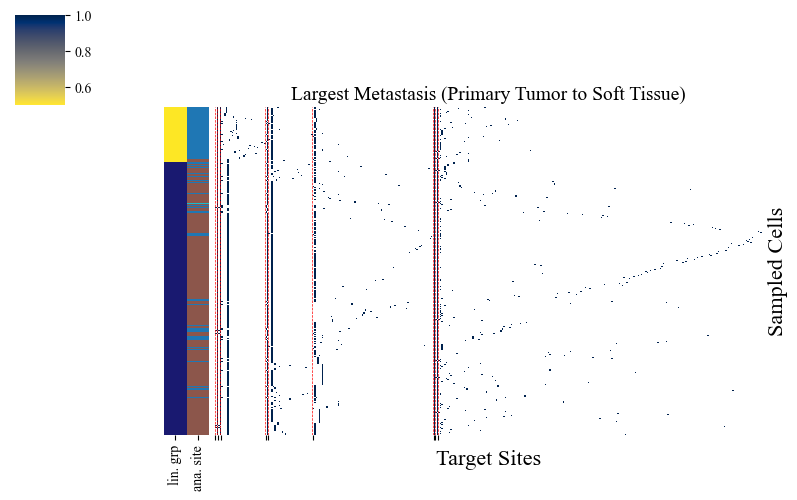

In [44]:
# Prepare the data
plt.rcParams['font.family'] = 'Times New Roman'

tmp_df = binarized_df

row_colors = pd.DataFrame({'lin. grp': np.where(tmp_df.index.isin(leafset_child), '#191970', '#FDE725'),
                           'ana. site': tmp_meta['color'], 
                          }, index=tmp_df.index)
cmap = plt.get_cmap('cividis_r')
cmap.set_bad('pink')
cmap.set_under('white')
tmp_df = tmp_df.mask(tmp_df == -1, np.nan) #(tmp_df, -1)

#mask = tmp_df.mask(tmp_df == -1, True) 
#values = g.ax_heatmap.collections[0].get_array().reshape(tmp_df.shape)
#new_values = np.ma.array(values, mask=mask) # true indicates masked invalid data
#g.ax_heatmap.collections[0].set_array(new_values)


# Create the clustermap
g = sns.clustermap(tmp_df, 
                   annot=False, 
                   fmt="d", 
                   row_cluster=False,
                   col_cluster=False,
                   row_colors=row_colors, vmin=0.5,
                   figsize=(10, 5), cmap=cmap)

# Show x-axis ticks for every column
g.ax_heatmap.set_xticks(vertical_lines)  # Set ticks only at vertical line positions
# g.ax_heatmap.set_xticklabels([tmp_df.columns[x][:-3] for x in vertical_lines], rotation=45, fontsize=8)  # Set corresponding labels
# g.ax_heatmap.xaxis.labelpad = 10  # Increase padding between axis and labels


for x in vertical_lines:
    g.ax_heatmap.axvline(x=x - 0.5, linewidth=0.5, color="red", linestyle="dashed")  # Adjust to align between columns

# Remove y-axis ticks
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_xlabel("Target Sites", fontsize=16)

g.ax_heatmap.set_ylabel("Sampled Cells", fontsize=16)
g.ax_heatmap.set_title("Largest Metastasis (Primary Tumor to Soft Tissue)", fontsize=14)

plt.savefig("/Users/gc3045/scmail_v1/sc-mail-experiments/Real_biodata/kptracer/migration_analysis/metastasis_indels_laml.pdf")
# plt.show()

In [30]:
#FDE725

In [31]:
df_character_matrix_Fam_1.loc[leafset_child]

,r0,r1,r2,r3,r4,r5,r6,r7,r8
cell,,,,,,,,,
L11.AAGACCTTCCAGAAGG-1,2,2,5,2,39,0,2,2,11
L9.GACCTGGGTCAGAAGC-1,2,2,5,2,2,0,2,2,11
L9.GCTGCGATCGCGCCAA-1,2,2,-1,-1,2,0,2,2,11
L11.CGCTATCTCACAAACC-1,2,2,5,2,2,82,2,2,11
L11.ATAACGCTCCTTTACA-1,2,2,5,2,38,0,2,2,7
...,...,...,...,...,...,...,...,...,...
L11.TGGTTAGTCAGCGACC-1,2,2,5,2,13,0,2,2,4
L11.CTTTGCGCATTAGGCT-1,2,2,5,2,13,0,2,2,8
L11.TCATTTGTCAGCATGT-1,2,2,5,2,15,0,2,2,2


In [32]:
# how big is the average anatomical clade


# meta purity statistic [cass]

In [33]:
# most common indel in this set

df_character_matrix_Fam_1.loc[leafset1]

NameError: name 'leafset1' is not defined

In [34]:
df_character_matrix_Fam_1.loc[leafset2]

NameError: name 'leafset2' is not defined

In [35]:
df_character_matrix_Fam_1['r2'].value_counts()

r2
3     549
5     492
2     156
-1    146
12     26
14     13
4      10
13      7
15      6
9       5
27      5
6       4
11      3
22      3
21      3
10      3
8       3
34      2
7       2
24      2
25      2
0       2
36      1
35      1
37      1
30      1
33      1
32      1
31      1
20      1
29      1
28      1
26      1
23      1
19      1
18      1
17      1
16      1
38      1
Name: count, dtype: int64

In [36]:
# df_kp_meta
tmp = df_kp_meta[df_kp_meta['MetFamily'] == '3724_NT_T1']['SubTumor'] == "3724_NT_S1_3"

In [37]:
df_kp_meta.loc[leafset2]

NameError: name 'leafset2' is not defined

In [61]:
human_readable = {'3724_NT_L3': 'lung-metastasis-3',
                  '3724_NT_L2': 'lung-metastasis-2',
                  '3724_NT_L1': 'lung-metastasis-1',
                  '3724_NT_S1': 'soft-tissue-metastasis-1',
                  '3724_NT_T1': 'primary-tumor',
                 }

In [62]:
def compute_edit_distance(cmat, cell_names):
    tmp_df = cmat.loc[cell_names]
    missing_char = -1
    def edit_distance(x, y, missing_char, ignore_missing=True):
        # assumes aligned
        d = 0

        assert len(x) == len(y)

        for i in range(len(x)):
            if ignore_missing:
                # print(i, x[i], y[i])
                if x[i] == missing_char or y[i] == missing_char:
                    continue

            if x[i] != y[i]:
                d += 1
        return d
    
    all_ed = []
    for x in tmp_df.index:
        for y in tmp_df.index:
            
            seq_x, seq_y = tmp_df.loc[x].values, tmp_df.loc[y].values
            ed = edit_distance(seq_x, seq_y, missing_char, ignore_missing=True)
            all_ed.append(ed)
    return all_ed

In [63]:
# get all the metastasis groups and compute the edit distance

metastasis_groups = {}
for edge in transition_heights: 
    f, t = edge

    branch_start, branch_end, branch_type = transition_heights[edge]

    # get earliest transition
    if branch_type == "p2n_transition": 
        
        #subtree = nx.dfs_tree(input_tree, source=edge[0])
        #leafset_parent = [n for n in subtree.nodes() if subtree.out_degree(n) == 0]
        #ed_parent = compute_edit_distance(df_character_matrix_Fam_1, leafset_parent)
        
        subtree = nx.dfs_tree(input_tree, source=edge[1])
        leafset_child = [n for n in subtree.nodes() if subtree.out_degree(n) == 0]
        #f len(leafset_child) > 0
        ed_child = compute_edit_distance(df_character_matrix_Fam_1, leafset_child)
        metastasis_groups[edge] = ed_child #np.mean(ed_child)
        

In [67]:
np.mean([np.mean(metastasis_groups[x])/9 for x in metastasis_groups if len(metastasis_groups[x]) > 5])

0.2421425151420571

In [68]:
np.median([np.median(metastasis_groups[x])/9 for x in metastasis_groups if len(metastasis_groups[x]) > 5])

0.2222222222222222

In [66]:
np.mean([np.sqrt(len(metastasis_groups[x])) for x in metastasis_groups])

10.194029850746269

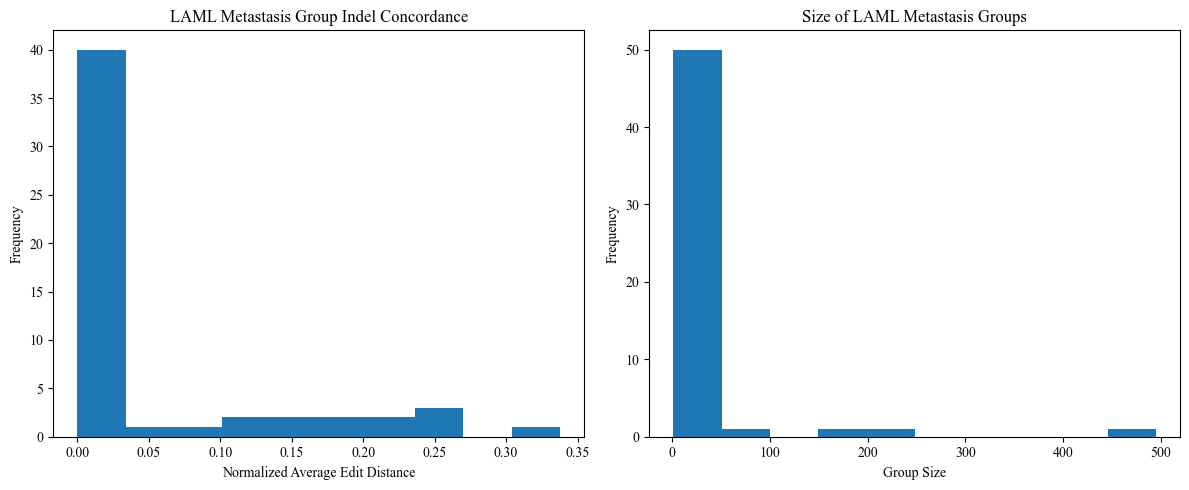

In [446]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first histogram
ax1.hist([np.mean(metastasis_groups[x])/9 for x in metastasis_groups])
ax1.set_title('LAML Metastasis Group Indel Concordance')
ax1.set_xlabel('Normalized Average Edit Distance')
ax1.set_ylabel('Frequency')

# Plot the second histogram
ax2.hist([np.sqrt(len(metastasis_groups[x])) for x in metastasis_groups])
ax2.set_title('Size of LAML Metastasis Groups')
ax2.set_xlabel('Group Size')
ax2.set_ylabel('Frequency')

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig("/Users/gc3045/scmail_v1/sc-mail-experiments/Real_biodata/kptracer/migration_analysis/metastasis_group_indels_laml.pdf")
# plt.show()